# Complex Bayesian Network notebook

#### Import dependencies

In [18]:
# Import dependencies
#%pip install pgmpy
#%pip install tabulate
#%pip install pandas
#%pip install networkx
#%pip install matplotlib

#### Load libraries

In [19]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sklearn

## Data import and cleaning

#### Import BigPerf data

In [20]:
# Import data
df = pd.read_csv("C:\\Users\\Keir McGlinn-Shaw\\Documents\\Stage-3\\Dissertation\\Data\\Use\\BigPerfMetrics.csv")

df.head()

,Block_ID,HDFS_BW,HDFSTranmissionTime,Mapper_ID,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_ID,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_ID.1,Block_BW,BlockTransmissionTime,TransactionTime
0,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer0,341739,480,3.80,250.14,reducer0_Block_1,0.0,0.00,1578.79
1,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer1,150000,120,50.00,18.99,reducer1_Block_1,50.0,20.00,1007.64
2,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer2,382530,480,4.48,212.22,reducer2_Block_1,3.7,270.02,1811.61
3,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer3,150000,120,5.88,161.57,reducer3_Block_1,3.7,270.02,1400.96
4,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,18.41,4.16,reducer4,457419,480,5.88,161.53,reducer4_Block_1,3.7,270.02,1761.83


#### Clean data of unwanted variables and missing values

In [21]:
# Clean data
df.dropna()

df.drop(labels=['Block_ID', 'Mapper_ID', 'Reducer_ID', 'Block_ID.1'], axis=1, inplace=True)

df.head()

,HDFS_BW,HDFSTranmissionTime,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_BW,BlockTransmissionTime,TransactionTime
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83


#### Rename columns to better fit in drawn charts and for ease of use

In [22]:
# Rename column headers to abbreviations

nodes = ['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT', 'TT']

df.columns = nodes

df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83
5,11.81,80.63,652289,765.49,18.41,4.16,150000,120,6.98,136.24,3.7,270.02,1376.54
6,11.81,80.63,652289,765.49,18.41,4.16,563904,480,3.80,250.14,3.7,270.02,1850.44
7,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63
8,11.81,80.63,652289,765.49,18.41,4.16,430890,480,3.80,250.14,3.7,270.02,1850.44
9,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63


#### Define funtion to discretise data into three catagories

In [23]:
'''
Splits data into three bins of equal size using: https://pandas.pydata.org/docs/reference/api/pandas.cut.html
'''
def split_tertiles(df):
    tertile_labels = ['Low', 'Medium', 'High']

    tert_df = pd.DataFrame()

    for column_name in df:
        tert_df[column_name] = pd.cut(df[column_name], 3, labels=tertile_labels, ordered=True)

    # Change type of values stored in dataframe to avoid errors arrising from using the Category type when the dataframe is fed into the pgmpy.metrics.metrics correlation_score function
    tert_df = tert_df.astype('object')

    return tert_df

#### Discretise data into catagories

In [24]:
# Discretise BigPerf dataset
cat_df = split_tertiles(df)

cat_df.head()

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,High,Low,Low,Low,High,Low,Medium,High,Low,High,Low,Low,Low
1,High,Low,Low,Low,High,Low,Low,Low,Low,Low,High,Low,Low
2,High,Low,Low,Low,Medium,Low,Medium,High,Low,High,Low,High,Medium
3,High,Low,Low,Low,Medium,Low,Low,Low,Low,Medium,Low,High,Low
4,High,Low,Low,Low,Medium,Low,High,High,Low,Medium,Low,High,Medium


In [25]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(cat_df, test_size=0.2, random_state=20)

## Building the model

#### Import dependencies

In [26]:
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch

#### Use structure learning to build a DAG

In [27]:
hc = HillClimbSearch(data=training_data)
estimate = hc.estimate(scoring_method='k2score')

  0%|          | 0/1000000 [00:00<?, ?it/s]

#### Generate a Bayesian Network object using the learned DAG

In [28]:
model = BayesianNetwork(estimate)

#### Fit the created BN model to the BigPerf data, in order to create probability distributions

In [29]:
from pgmpy.estimators import BayesianEstimator, ExpectationMaximization, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML

# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []

model.fit(data=training_data,
    estimator=BayesianEstimator,
    prior_type='BDeu',
    complete_samples_only=True)

#### Plot the model as a graph

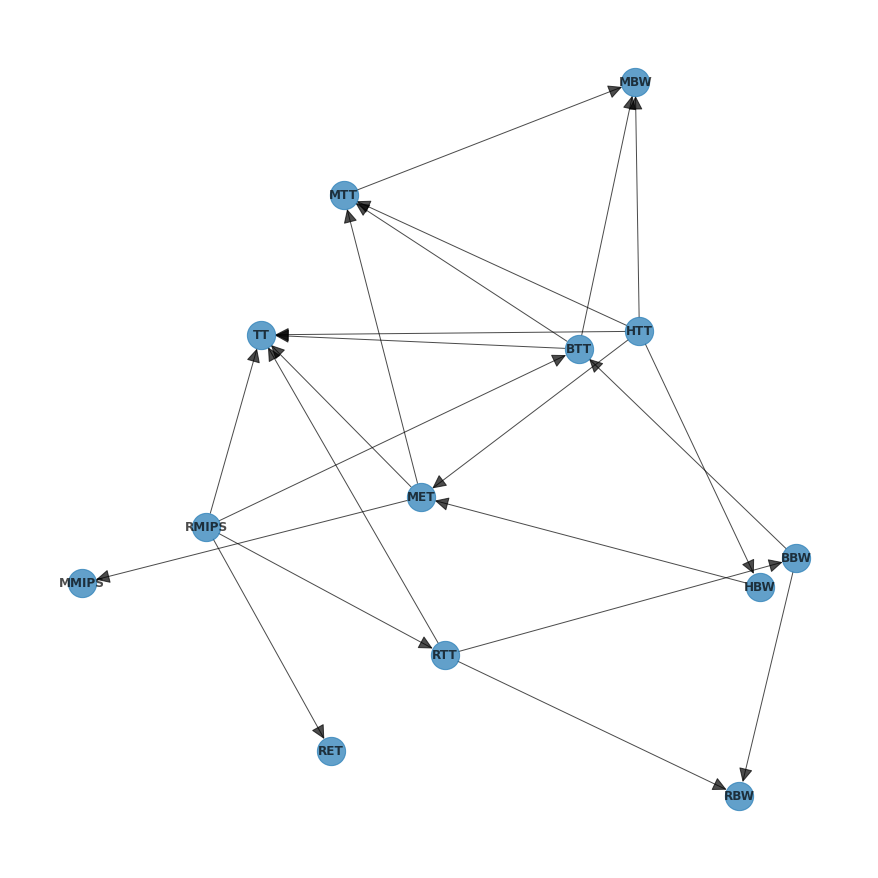

In [30]:
plt.figure(3,figsize=(12,12)) 
G = nx.DiGraph()
G.add_edges_from(model.edges)
G.add_nodes_from(model.nodes)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True, arrowsize=30, node_size=800, alpha=0.7, font_weight="bold")  # Draw the original graph
plt.show()

## Scoring the model

#### Run scoring functions on the model to collect metrics of correctness

In [31]:
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

f1 = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
pr = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ls = log_likelihood_score(model=model, data=testing_data)
ss = structure_score(model=model, data=testing_data, scoring_method='bdeu')


print(f'F1 score: {f1}')
print(f'Accuracy score: {acc}')
print(f'Precision score: {pr}')
print(f'Recall score: {recall}')
print(f'Log-likilihood score: {ls}')
print(f'Structure score: {ss}')

print(model.name)

F1 score: 0.888888888888889
Accuracy score: 0.9230769230769231
Precision score: 1.0
Recall score: 0.8
Log-likilihood score: -2373.9190452143293
Structure score: -2673.2894655836835



In [32]:
def store_metrics(metrics_file_name, model_name, f1, accuracy, precision, recall, log_likelihood_score, structure_score):
    try: 
        df = pd.read_csv('Model-metrics.csv', header=0, index_col=False)
    except:
        df_columns = ['Model', 'F1', 'Accuracy', 'Precision', 'Recall', 'Log likelihood score', 'Structure score']

        df = pd.DataFrame(columns=df_columns)

    else:
        df = df[df.Model != model_name]
        
    new_row = {'Model': model_name, 'F1': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'Log likelihood score': log_likelihood_score, 'Structure score': structure_score}

    df = df.append(new_row, ignore_index=True)

    # Write to file
    df.to_csv(metrics_file_name, index=False)

In [33]:
model_name = 'Score-based CBN'
metrics_file_name = 'Model-metrics.csv'

store_metrics(metrics_file_name=metrics_file_name, model_name=model_name, f1=f1, accuracy=acc, precision=pr, recall=recall, log_likelihood_score=ls, structure_score=ss)

C:\Users\KEIRMC~1\AppData\Local\Temp/ipykernel_6828/4032907300.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


#### Print the model's probability distributions

In [34]:
print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of HBW:
+-----------+----------------------+----------------------+
| HTT       | HTT(High)            | HTT(Low)             |
+-----------+----------------------+----------------------+
| HBW(High) | 0.001392757660167131 | 0.9857393593681439   |
+-----------+----------------------+----------------------+
| HBW(Low)  | 0.9986072423398329   | 0.014260640631856078 |
+-----------+----------------------+----------------------+ 

CPT of HTT:
+-----------+----------+
| HTT(High) | 0.440599 |
+-----------+----------+
| HTT(Low)  | 0.559401 |
+-----------+----------+ 

CPT of MMIPS:
+---------------+-----+-----------------------+
| MET           | ... | MET(Medium)           |
+---------------+-----+-----------------------+
| MMIPS(High)   | ... | 0.0008965393580778197 |
+---------------+-----+-----------------------+
| MMIPS(Low)    | ... | 0.0008965393580778197 |
+---------------+-----+-----------------------+
| MMIPS(Medium) | ... | 0.9982069212838444    |
+---------